# Projet 5 - Segmentez des clients d'un site e-commerce (Partie 2)

> 🎓 OpenClassrooms • Parcours [AI Engineer](https://openclassrooms.com/fr/paths/795-ai-engineer) | 👋 *Etudiant* : [David Scanu](https://www.linkedin.com/in/davidscanu14/)

## 📊 Partie 2 : Apprentissage non supervisé

Ce notebook explore l’application de l’**apprentissage non supervisé** pour segmenter les clients en groupes homogènes en fonction de leur comportement d'achat (RFM) et de satisfaction (score de satisfaction). Nous testons plusieurs méthodes de clustering afin d'identifier la segmentation la plus pertinente pour l'équipe marketing. Enfin, nous analysons la **stabilité des segments dans le temps** pour recommander une **fréquence optimale de mise à jour du modèle** (dans un 3ème notebook).

<img src="https://user.oc-static.com/upload/2023/03/21/16793895608947_Screenshot%202023-03-21%20at%2010.05.50.png" width="720" />

## ⚡ Mission

Nous sommes **consultant pour Olist** et nous avons été chargé de **réaliser cette segmentation**, en mettant en place des modèles d'**apprentissage non supervisé** et en fournissant un **plan de maintenance** du modèle.

**Segmentation client**

- Explorer et analyser les données fournies.
- Mettre en place une segmentation des clients en utilisant des algorithmes d’apprentissage non supervisé (ex. clustering).
- Fournir une analyse approfondie des segments obtenus pour une exploitation optimale par l'équipe Marketing.
- Proposer un plan de maintenance basé sur une simulation de fréquence de mise à jour du modèle.

## Documentation

- [Google Docs Notes](https://docs.google.com/document/d/1Bpxbg2jaFZpI605kQhOoR84H2_EpTwBdUt-xk82wsfM/edit?usp=sharing)
- https://github.com/Faroja/Olist-Customers-Segementation
- https://towardsdatascience.com/simple-customer-segmentation-using-rfm-analysis-1ccee2b6d8b9
- https://stackoverflow.com/questions/59315132/how-to-get-which-semester-a-day-belongs-to-using-pandas-period

## PEP8

- https://openclassrooms.com/fr/courses/7160741-ecrivez-du-code-python-maintenable/7187494-decouvrez-les-conventions-python
- https://peps.python.org/pep-0008/

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.ticker import MaxNLocator

## Chargement des données "RFM+S"

Nous chargeons les données clients "RFM+S", précedemment exportés dans le notebook `p05-david_scanu_02_notebook_exploration_20250117.ipynb`.


In [2]:
data_dir = './content/data'

# Liste tous les fichiers .csv dans le répertoire
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]

# Charger chaque fichier .csv dans un dataframe séparé
RFM_data = {}
for file in csv_files:
  file_path = os.path.join(data_dir, file)
  df_name = os.path.splitext(file)[0]
  RFM_data[df_name] = pd.read_csv(file_path, index_col='customer_unique_id')

# Display the names of the dataframes loaded
print("Dataframes loaded:")
for item in RFM_data.keys():
    print(f"- {item}")

Dataframes loaded:
- rfm_2018Q3
- rfm_2016Q4
- rfm_2017Q2
- rfm_2017Q4
- rfm_2017Q1
- rfm_2018Q2
- rfm_2018Q1
- rfm_2017Q3


In [3]:
RFM_data['rfm_2017Q1'].head()

,recency,frequency,monetary_value,avg_review_score
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,21,1,86.22,3.0
0005e1862207bf6ccc02e4228effd9a0,27,1,150.12,4.0
00115fc7123b5310cf6d3a3aa932699e,69,1,76.11,4.0
001f3c4211216384d5fe59b041ce1461,12,1,35.84,3.0
002043098f10ba39a4600b6c52fbfe3c,5,1,237.81,4.0


In [4]:
RFM_data['rfm_2017Q1'].columns

Index(['recency', 'frequency', 'monetary_value', 'avg_review_score'], dtype='object')

## Prétraitement variables

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Normalization of data
RFM_data_scaled = {}
RFM_data_scaler = {}

for key in RFM_data:
    # Créer un scaler
    RFM_data_scaler[key] = StandardScaler()
    
    # Normaliser uniquement les colonnes numériques
    numeric_columns = ['recency', 'frequency', 'monetary_value', 'avg_review_score']
    
    # Effectuer la normalisation tout en préservant l'index
    data_scaled = RFM_data_scaler[key].fit_transform(RFM_data[key][numeric_columns])
    
    # Créer un DataFrame normalisé avec l'index original
    RFM_data_scaled[key] = pd.DataFrame(
        data_scaled, 
        columns=numeric_columns, 
        index=RFM_data[key].index
    )

In [6]:
RFM_data_scaled['rfm_2017Q1'].head()

,recency,frequency,monetary_value,avg_review_score
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,-0.551028,-0.120538,-0.312936,-0.966192
0005e1862207bf6ccc02e4228effd9a0,-0.273232,-0.120538,-0.067541,-0.151965
00115fc7123b5310cf6d3a3aa932699e,1.671341,-0.120538,-0.351761,-0.151965
001f3c4211216384d5fe59b041ce1461,-0.967722,-0.120538,-0.506410,-0.966192
002043098f10ba39a4600b6c52fbfe3c,-1.291818,-0.120538,0.269214,-0.151965


In [7]:
RFM_data_scaled['rfm_2017Q1'].shape

(4849, 4)

## Clustering

### ⚖️ **L’équilibre entre trop de clusters et pas assez**  

Lorsque l'on choisit le nombre de clusters (*k*) dans un algorithme de clustering comme K-Means, il faut trouver un équilibre entre **sous-segmentation** (pas assez de clusters) et **sur-segmentation** (trop de clusters).  

#### 🔴 **Pas assez de clusters (k trop petit)**  

- Les groupes sont trop larges et hétérogènes.  
- Perte d’informations : des clients aux comportements différents sont regroupés ensemble.  
- La segmentation devient peu exploitable pour le marketing ou la prise de décision.  

#### 🟢 **Nombre optimal de clusters (bon équilibre)**  

- Les groupes sont homogènes et exploitables.  
- La segmentation est claire et utile pour l’entreprise.  
- Les différences entre segments sont significatives.  

#### 🔵 **Trop de clusters (k trop grand)**  

- Chaque cluster devient très petit et spécifique.  
- Risque de sur-ajustement (*overfitting*) : la segmentation ne généralise pas bien.  
- Complexité inutile : difficile à interpréter et à utiliser en pratique.  

### 🎯 **Comment trouver le bon équilibre ?**  

Le choix du nombre optimal de clusters (*k*) est crucial pour obtenir une segmentation pertinente. Plusieurs méthodes peuvent être utilisées pour déterminer la meilleure valeur de *k*, parmi lesquelles :

- Utiliser la **méthode du coude** pour identifier un point où l'inertie n’évolue plus significativement.  
- Vérifier le **coefficient de silhouette** pour maximiser la séparation entre clusters.  
- Prendre en compte la **faisabilité métier** : un trop grand nombre de segments peut être inutilisable pour une équipe marketing.  

L’objectif est d’avoir **suffisamment de clusters pour capturer les comportements distincts, mais pas trop pour garder une segmentation exploitable.**

### La méthode du coude (*Elbow Method*)

La **méthode du coude** est une approche couramment utilisée pour déterminer le nombre optimal de clusters dans un algorithme K-Means. Elle repose sur l’analyse de l’**inertie intra-cluster** (somme des distances des points à leur centre de cluster).  

On trace cette inertie en fonction du nombre de clusters (*k*). Initialement, l’inertie diminue fortement, mais au-delà d’un certain *k*, la réduction devient marginale, formant un **point de coude** sur la courbe. Ce point correspond au nombre optimal de clusters, car il équilibre précision et simplicité du modèle.  

Bien que cette méthode soit efficace, elle doit être complétée par d’autres indicateurs comme le **coefficient de silhouette** pour confirmer la pertinence du choix de *k*. 🚀

*Remarque* : Within-Cluster Sum of Squares (WCSS), Sum of Squared Distances (SSD) et inertie intra-cluster sont synonymes et servent à évaluer la cohésion des clusters.

**Documentation**

- https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [8]:
def calculate_ssd(data, k_max=20):
  """
  Calcule la somme des distances au carré pour différents nombres de clusters
  """
  # Calculer la somme des distances au carré pour différents nombres de clusters
  sse = {}
  for k in range(1, k_max):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300, tol=1e-4)
    kmeans.fit(data)
    sse[k] = kmeans.inertia_
  return sse

ssd = calculate_ssd(RFM_data_scaled['rfm_2017Q1'])

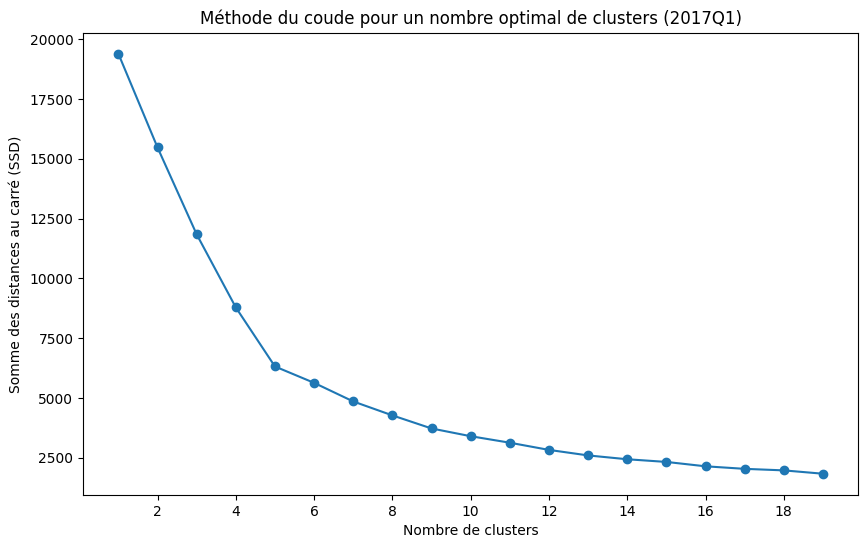

In [9]:
# Tracer le SSE pour chaque nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(list(ssd.keys()), list(ssd.values()), marker='o')
plt.title('Méthode du coude pour un nombre optimal de clusters (2017Q1)')
plt.xlabel('Nombre de clusters')
plt.ylabel('Somme des distances au carré (SSD)')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

La **méthode du coude** semble indiquer que le nombre optimal de clusters est de **5**.

### Le coefficient de silhouette (*Silhouette Score*) :  

- Cette métrique évalue la cohésion interne des clusters en mesurant à quel point chaque point est bien regroupé avec ses voisins.  
- Il est compris entre -1 et 1 :
  - **Proche de 1** : L’individu est bien assigné à son cluster.
  - **Proche de 0** : L’individu est à la frontière entre deux clusters.
  - **Proche de -1** : L’individu serait mieux placé dans un autre cluster.  
- On teste plusieurs valeurs de *k* et on choisit celle qui maximise le score de silhouette.  

Le **coefficient de silhouette** (*Silhouette Score*) doit être **élevé** pour indiquer un bon clustering.  

**Interprétation du coefficient de silhouette**  

Le *Silhouette Score* mesure la **qualité du regroupement des clusters** en évaluant à la fois :  
- **La cohésion intra-cluster** : à quel point un point est proche des autres points de son cluster.  
- **La séparation inter-cluster** : à quel point un point est éloigné des clusters voisins.  

### 🎯 **Interprétation des valeurs de silhouette**  
- **\( S \) proche de 1** → Segmentation bien définie (les points sont bien regroupés et bien séparés). ✅  
- **\( S \) proche de 0** → Les clusters se chevauchent, mauvaise séparation. ⚠️  
- **\( S \) négatif** → Mauvais clustering (les points sont plus proches d'un autre cluster que du leur). ❌  

In [39]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def calculate_silhouette_scores(data, k_max=20):
  """
  Calcule les scores de silhouette pour différents nombres de clusters

  Args: 
  - data: les données à utiliser pour le clustering.
  - range_n_clusters: une liste de nombres de clusters à tester.

  Returns:
  - silhouette_scores: un dictionnaire contenant les scores de silhouette pour chaque nombre de clusters.
  """
  # Dictionnaire pour stocker les scores de silhouette
  silhouette_scores = {}
  # Itérer sur la plage de clusters
  for n_clusters in list(range(2, k_max)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300, tol=1e-4)
    cluster_labels = kmeans.fit_predict(data)
    # Calculer le score de silhouette
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores[n_clusters] = silhouette_avg
    print(f"Pour n_clusters = {n_clusters}, le score de silhouette moyen est {silhouette_avg:.4f}")
  return silhouette_scores

silhouette_scores = calculate_silhouette_scores(RFM_data_scaled['rfm_2017Q1'])

Pour n_clusters = 2, le score de silhouette moyen est 0.7219
Pour n_clusters = 3, le score de silhouette moyen est 0.3504
Pour n_clusters = 4, le score de silhouette moyen est 0.4165
Pour n_clusters = 5, le score de silhouette moyen est 0.4344
Pour n_clusters = 6, le score de silhouette moyen est 0.4355
Pour n_clusters = 7, le score de silhouette moyen est 0.4442
Pour n_clusters = 8, le score de silhouette moyen est 0.4022
Pour n_clusters = 9, le score de silhouette moyen est 0.4119
Pour n_clusters = 10, le score de silhouette moyen est 0.3514
Pour n_clusters = 11, le score de silhouette moyen est 0.3625
Pour n_clusters = 12, le score de silhouette moyen est 0.3696
Pour n_clusters = 13, le score de silhouette moyen est 0.3702
Pour n_clusters = 14, le score de silhouette moyen est 0.3781
Pour n_clusters = 15, le score de silhouette moyen est 0.3751
Pour n_clusters = 16, le score de silhouette moyen est 0.3731
Pour n_clusters = 17, le score de silhouette moyen est 0.3837
Pour n_clusters 

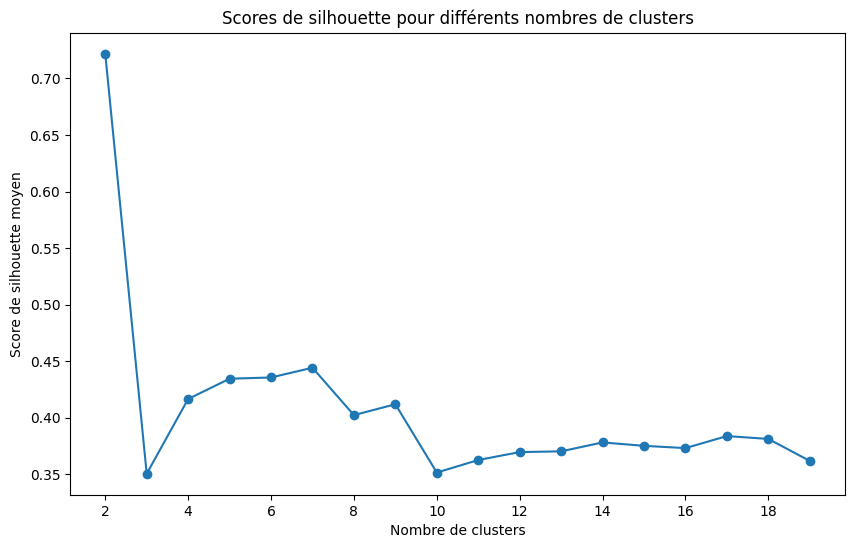

In [40]:
# Tracer les scores de silhouette
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
plt.title('Scores de silhouette pour différents nombres de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette moyen')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

**Comment interpréter cette tendance ?**  
- Le **score optimal est généralement atteint pour un \( k \) qui équilibre bien séparation et cohésion**.  
- Ici, \( k = 2 \) a le meilleur score, mais cela peut être trop peu pour une segmentation utile.  
- Il faut trouver **un compromis entre score de silhouette et pertinence métier**.  

**Que faire ensuite ?**  

- **Examiner les clusters visuellement** (via PCA ou t-SNE) pour vérifier s’ils sont pertinents.  
- **Croiser avec d'autres critères** comme la méthode du coude (inertie intra-cluster).  
- **Prendre en compte l'objectif métier** pour choisir un \( k \) optimal.  


### Nombre de clusters choisis : 7

Nous choisissons **7 clusters** pour la segmentation RFM des clients en me basant sur l'analyse de la **méthode du coude** et du **score de silhouette**. Le score de silhouette a montré une meilleure cohésion et séparation des clusters autour de 5 et 6 clusters, avec un léger avantage pour 5. De plus, la méthode du coude a révélé une cassure (peu marquée) à 5 clusters, suggérant que c'était un bon compromis entre une segmentation fine et une structure claire des données. Ce choix permet ainsi une segmentation efficace et bien définie des clients.

Nous calculons le clustering pour 5 clusters avec la méthode `KMeans`, pour chaque trimestre. 

In [110]:
from sklearn.cluster import KMeans

def calculate_kmeans(og_data_dict, scaled_data_dict, n_clusters=5):
  """
  Calcule les clusters pour chaque jeu de données (trimestres) et ajoute les étiquettes de cluster au DataFrame d'origine.

  Args:
  - og_data_dict: un dictionnaire contenant les DataFrames d'origine.
  - scaled_data_dict: un dictionnaire contenant les DataFrames normalisés.
  - n_clusters: le nombre de clusters à utiliser.

  Returns:
  - og_data_dict: un dictionnaire contenant les DataFrames d'origine avec les étiquettes de cluster ajoutées.
  """
  for key in og_data_dict:
    # Utiliser KMeans pour effectuer le clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300, tol=1e-4)
    cluster_labels = kmeans.fit_predict(scaled_data_dict[key])
    # Ajouter les étiquettes de cluster au DataFrame d'origine
    og_data_dict[key]['cluster'] = cluster_labels  
  return og_data_dict

RFM_data_clustered = calculate_kmeans(RFM_data, RFM_data_scaled, n_clusters=5)

In [ ]:
def display_clusters_sizes(clustered_data_dict, cluster_column='cluster'):
  for key in clustered_data_dict:
    print(f"Cluster sizes for {key}:")
    print(clustered_data_dict[key][cluster_column].value_counts())
    print("\n")

# display_clusters_sizes(RFM_data_clustered)

In [ ]:
def display_cluster_profiles(clustered_data_dict, cluster_column='cluster'):
  for key in clustered_data_dict:
    # Grouper les données par cluster
    cluster_profiles = clustered_data_dict[key].groupby(cluster_column).mean()
    print(f"Cluster profiles for {key}:")
    print(cluster_profiles)
    print("\n")

# display_cluster_profiles(RFM_data_clustered)

In [42]:
# Visualisation des clusters
RFM_data_clustered['rfm_2017Q1'].head()

,recency,frequency,monetary_value,avg_review_score,cluster
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,21,1,86.22,3.0,1
0005e1862207bf6ccc02e4228effd9a0,27,1,150.12,4.0,4
00115fc7123b5310cf6d3a3aa932699e,69,1,76.11,4.0,2
001f3c4211216384d5fe59b041ce1461,12,1,35.84,3.0,1
002043098f10ba39a4600b6c52fbfe3c,5,1,237.81,4.0,4


## Analyse et interprétation

Analysez les segments :
- Moyenne des variables R, F, M, et satisfaction par cluster.
- Identifier les segments clés : bons clients, clients à risque, etc.

Visualisez les clusters :
- Utilisez des graphiques 2D ou 3D (e.g., PCA ou t-SNE) pour visualiser la segmentation.

Validez la segmentation :
- Utilisez des métriques comme le silhouette score pour évaluer la cohérence des clusters.

### TSNE

Le t-SNE (t-Distributed Stochastic Neighbor Embedding) est une méthode non supervisée de réduction de dimension qui projette des données complexes dans un espace 2D ou 3D tout en préservant les relations de proximité entre les points, facilitant leur visualisation. Le t-SNE vise à :

- Projeter des données multi-dimensionnelles dans un espace à faible dimension (souvent 2D ou 3D), tout en préservant les relations locales (c'est-à-dire les similarités entre les points proches dans l'espace d'origine).
- Faciliter la visualisation des données complexes, notamment lorsqu'elles contiennent des structures non linéaires difficiles à capturer par des techniques linéaires comme la PCA.

**Interprétation** 

- Si les clusters sont bien séparés dans l’espace t-SNE, cela confirme que votre segmentation capture bien des regroupements naturels.
- Si les clusters se mélangent beaucoup, cela peut indiquer que votre segmentation a besoin d'être affinée.

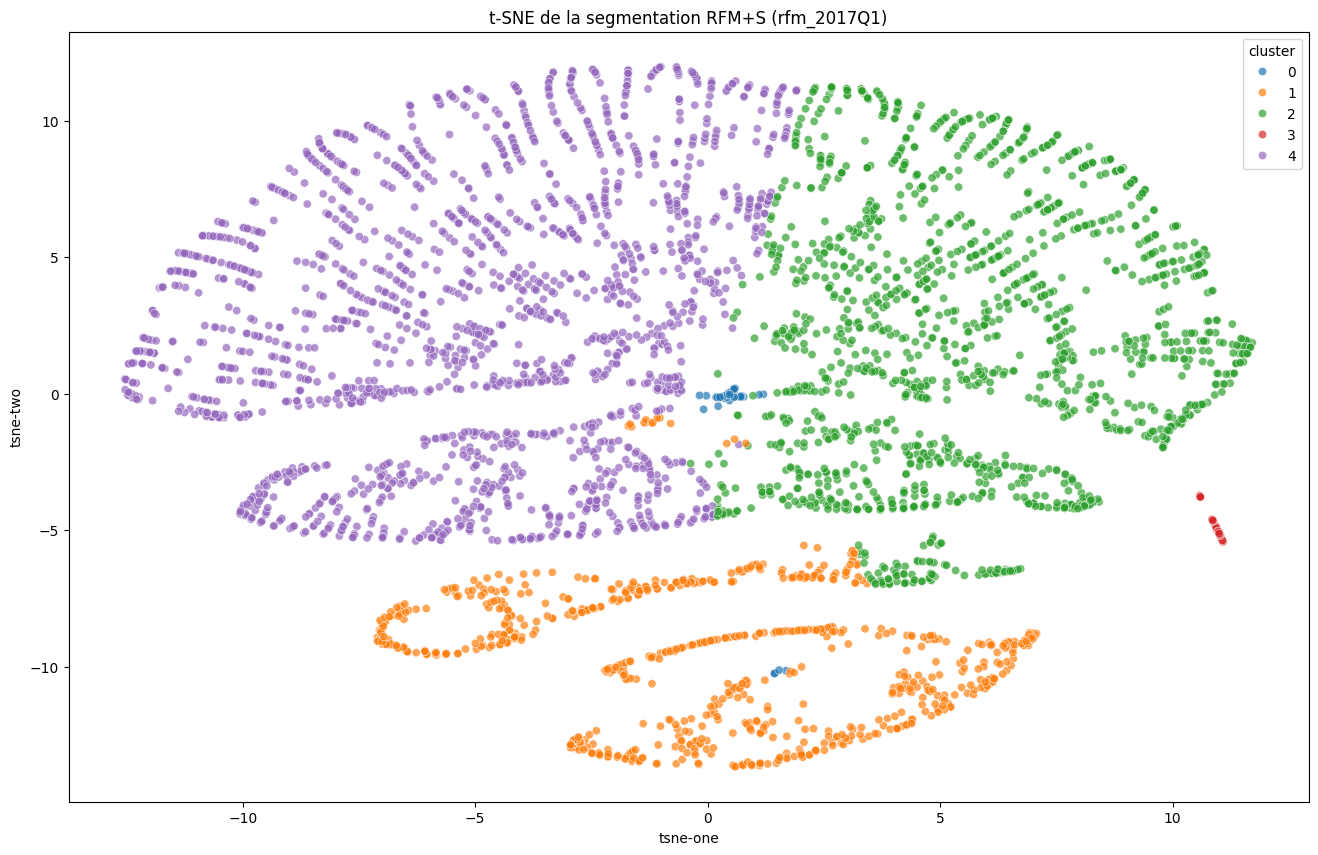

In [63]:
from sklearn.manifold import TSNE

def display_tsne(RFM_data_scaled, quarter_name):
    """
    Réduit les dimensions des données à l'aide de t-SNE et affiche les clusters.

    Args:
    - data: les données à réduire.
    - quarter_name: le nom du trimestre.

    Returns:
    - None
    """
    # Réduction de dimension avec t-SNE
    tsne = TSNE(n_components=2, perplexity=40, max_iter=300)
    tsne_results = tsne.fit_transform(RFM_data_scaled[quarter_name])

    # Créer un DataFrame pour stocker les résultats de t-SNE
    tsne_df = pd.DataFrame(tsne_results, columns=['tsne-one', 'tsne-two'], index=RFM_data_scaled[quarter_name].index)

    # Ajouter les étiquettes de cluster
    tsne_df['cluster'] = RFM_data_clustered[quarter_name]['cluster']

    # Tracer le t-SNE
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x="tsne-one", y="tsne-two",
        hue="cluster",
        palette=sns.color_palette("tab10", 5),
        data=tsne_df,
        legend="full",
        alpha=0.7
    )
    plt.title(f't-SNE de la segmentation RFM+S ({quarter_name})')
    plt.show()

display_tsne(RFM_data_scaled, 'rfm_2017Q1')

**Interprétation :**

1. **Clusters distincts :**
   - Les clusters apparaissent **relativement bien séparés**, ce qui indique que les données présentent des regroupements naturels cohérents.
   - Les **clusters 2 (orange)** et **4 (vert)** se distinguent particulièrement bien des autres, suggérant des caractéristiques uniques pour ces groupes.

2. **Chevauchements partiels :**
   - On observe un chevauchement entre certains points des clusters **1 (bleu)** et **3 (violet)**, indiquant que ces groupes partagent des similitudes dans leurs dimensions RFM.

3. **Taille des clusters :**
   - Le **cluster 3 (violet)** est le plus grand, ce qui pourrait représenter une majorité des clients partageant des comportements similaires.
   - Le **cluster 0 (rouge)** est très petit et isolé, ce qui pourrait correspondre à un groupe spécifique d'individus (par exemple, des clients VIP ou inactifs).

4. **Organisation dans l'espace :**
   - Les groupes sont disposés de manière cohérente dans l’espace t-SNE, indiquant que les relations locales dans les données initiales sont bien préservées.


**Actions possibles :**

- **Analyse approfondie :** Examiner les **caractéristiques RFM propres** à chaque cluster pour comprendre leurs différences comportementales.
- **Stratégies spécifiques :** Élaborer des actions marketing personnalisées en fonction des besoins et comportements des clients dans chaque cluster. Par exemple :
  - Le cluster **3 (violet)** pourrait représenter des clients réguliers nécessitant une fidélisation.
  - Le cluster **0 (rouge)** pourrait inclure des clients très spécifiques qui méritent une attention ciblée.

### Analyse en Composantes Principales (PCA)

La PCA est une méthode de réduction de dimension qui transforme les données en un espace de variables non corrélées appelées composantes principales.
Les premières composantes principales capturent la majorité de la variance dans les données, permettant une visualisation simplifiée en 2D tout en conservant l'essentiel de l'information.

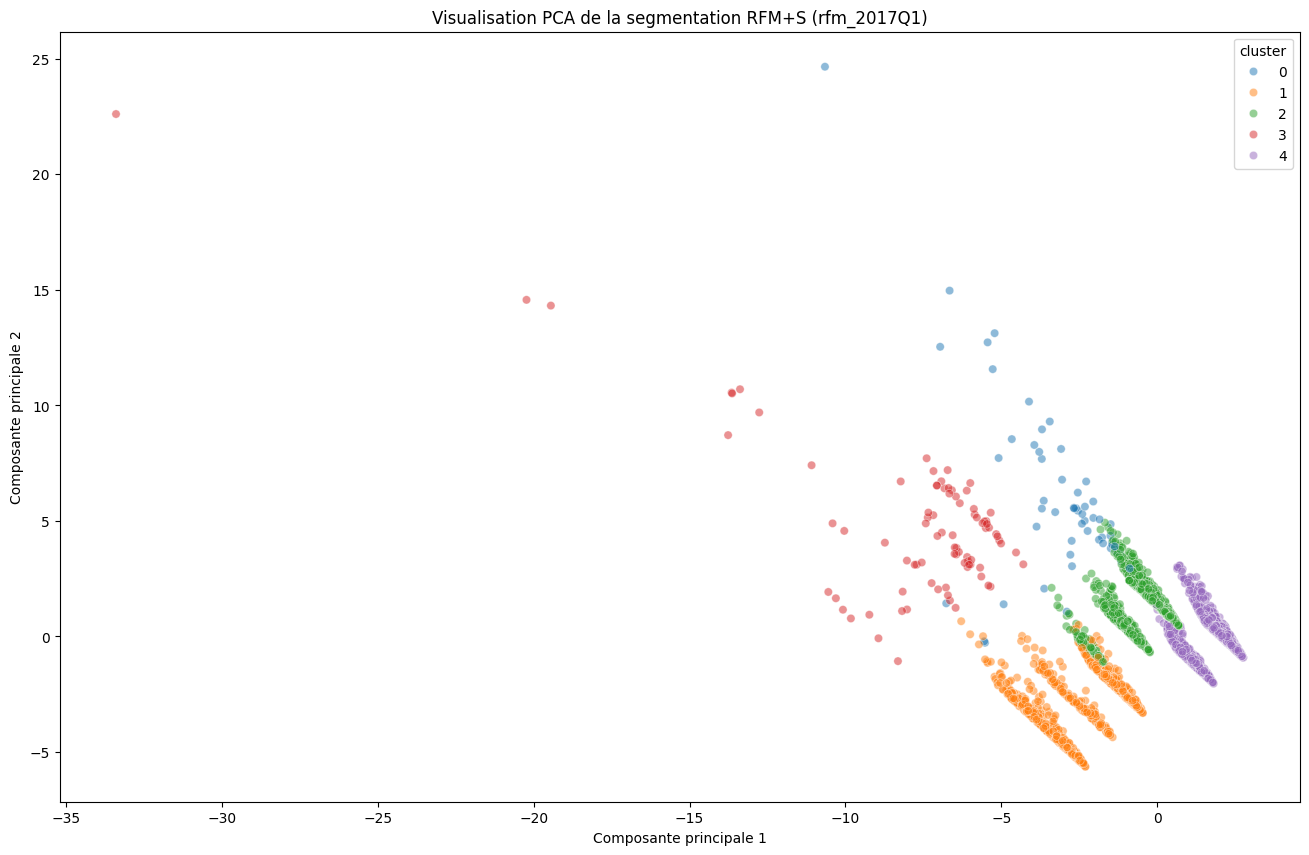

In [75]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def display_pca(df, quarter_name):
    """
    Effectue une PCA sur les données et affiche les clusters dans un plan 2D.

    Args:
    - RFM_data_scaled: DataFrame contenant les données standardisées.
    - quarter_name: le nom de la période (colonne).

    Returns:
    - None
    """
    # Réduction de dimensions avec PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df[quarter_name])

    # Créer un DataFrame pour les résultats PCA
    pca_df = pd.DataFrame(pca_results, columns=['PCA1', 'PCA2'], index=df[quarter_name].index)

    # Ajouter les étiquettes de cluster
    pca_df['cluster'] = RFM_data_clustered[quarter_name]['cluster']

    # Tracer la PCA
    plt.figure(figsize=(16, 10))
    sns.scatterplot(
        x="PCA1", y="PCA2",
        hue="cluster",
        palette=sns.color_palette("tab10", len(pca_df['cluster'].unique())),
        data=pca_df,
        legend="full",
        alpha=0.5
    )
    plt.title(f'Visualisation PCA de la segmentation RFM+S ({quarter_name})')
    plt.xlabel('Composante principale 1')
    plt.ylabel('Composante principale 2')
    plt.show()

# Appeler la fonction
display_pca(RFM_data_scaled, 'rfm_2017Q1')

**Interprétation**

Chaque point représente **un client (coloré selon son cluster)**.

Les clusters dans l'espace des deux premières composantes principales permettent de visualiser les regroupements basés sur les dimensions RFM.
La dispersion et les chevauchements entre clusters reflètent la variabilité des caractéristiques RFM et l'efficacité de la segmentation.

### Moyenne des variables R, F, M, et satisfaction par cluster.

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

def display_cluster_profiles_viz(cluster_means: pd.DataFrame, quarter_name: str):
    """
    Fonction pour afficher les profils de cluster sous forme de graphiques à barres.

    Args:
    - cluster_means: un DataFrame contenant les moyennes des variables par cluster.

    Returns:
    - None
    """

    # Initialise la fonction subplot en utilisant le nombre de lignes et de colonnes
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Ajouter un titre global pour les sous-graphiques
    fig.suptitle(f'Profils des clusters RFM+S pour le trimestre {quarter_name}', fontsize=16)

    # Fonction pour ajouter des étiquettes de valeur au-dessus des barres
    def add_value_labels(ax):
            for p in ax.patches:
                    if p.get_height() > 0:  # Avoid annotating legend elements
                            ax.annotate(f'{p.get_height():.2f}', 
                                                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                                                    ha='center', va='bottom', fontsize=10, color='black')

    # Récence par cluster
    ax = sns.barplot(x=cluster_means.index, y=cluster_means['recency'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[0, 0])
    axes[0, 0].set_title('Récence')
    axes[0, 0].set_xlabel('Cluster')
    axes[0, 0].set_ylabel('Récence')
    add_value_labels(ax)

    # Fréquence par cluster
    ax = sns.barplot(x=cluster_means.index, y=cluster_means['frequency'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[0, 1])
    axes[0, 1].set_title('Fréquence')
    axes[0, 1].set_xlabel('Cluster')
    axes[0, 1].set_ylabel('Fréquence')
    add_value_labels(ax)

    # Valeur monétaire par cluster
    ax = sns.barplot(x=cluster_means.index, y=cluster_means['monetary_value'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[1, 0])
    axes[1, 0].set_title('Valeur monétaire')
    axes[1, 0].set_xlabel('Cluster')
    axes[1, 0].set_ylabel('Valeur monétaire')
    add_value_labels(ax)

    # Score moyen des avis par cluster
    ax = sns.barplot(x=cluster_means.index, y=cluster_means['avg_review_score'], palette=sns.color_palette("tab10", 5), hue=cluster_means.index, ax=axes[1, 1])
    axes[1, 1].set_title('Score moyen des avis')
    axes[1, 1].set_xlabel('Cluster')
    axes[1, 1].set_ylabel('Score moyen des avis')
    add_value_labels(ax)

    # Ajuster la disposition pour un meilleur espacement
    plt.tight_layout()
    plt.show()

Nous affichons les **moyennes des variables RFM+S** pour chaque cluster, sous forme de diagramme en barres,  pour le trimestre '2017Q1'.

           recency  frequency  monetary_value  avg_review_score
cluster                                                        
0        32.771930   1.000000     1891.455263          4.491228
1        28.997714   1.000000      150.478126          1.956571
2        55.240283   1.000000      146.974623          4.640165
3        37.906977   2.162791      257.963953          3.953488
4        16.521331   1.000000      141.577398          4.741678


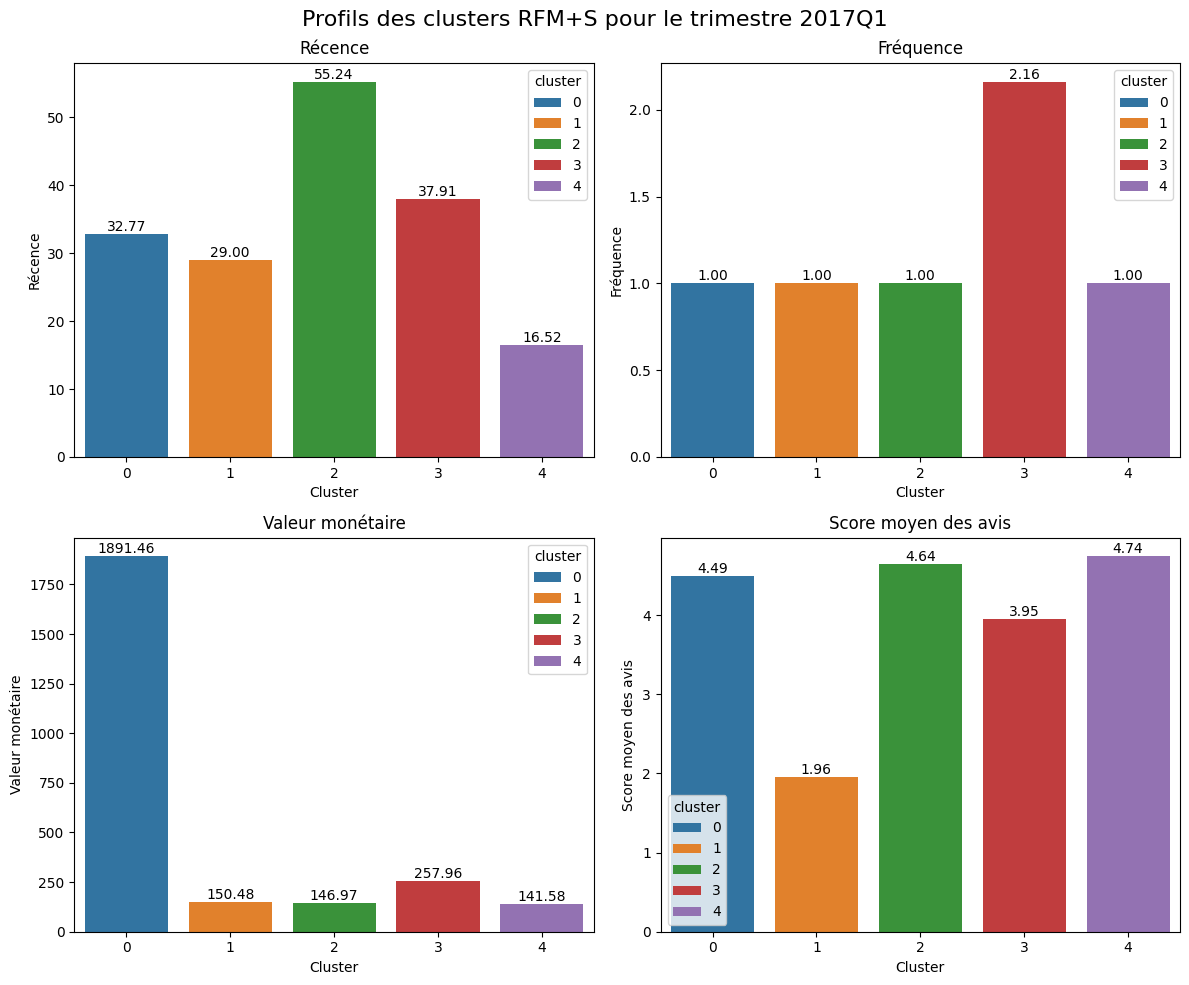

In [65]:
# Calculer la moyenne des variables par cluster
cluster_means = RFM_data_clustered['rfm_2017Q1'].groupby('cluster').mean()
print(cluster_means[['recency', 'frequency', 'monetary_value', 'avg_review_score']])
display_cluster_profiles_viz(cluster_means, '2017Q1')

### Interprétation et stratégie pour chaque cluster

#### **Cluster 0**
- **Interprétation :**  
  Ce groupe représente les clients avec une **très forte valeur monétaire** et une **note moyenne élevée**, mais une **faible récence et fréquence**. Cela signifie qu’ils ont dépensé beaucoup par le passé, mais ils ne reviennent pas souvent.  
- **Stratégie :**  
  Mettre en place une campagne de **réactivation ciblée**, par exemple via des offres exclusives ou des remises personnalisées, pour inciter ces clients premium à effectuer un nouvel achat.  

#### **Cluster 1**
- **Interprétation :**  
  Ces clients ont une **valeur monétaire faible**, une **récence moyenne** et une **note moyenne faible**. Cela suggère des clients peu engagés qui pourraient être insatisfaits ou simplement peu actifs.  
- **Stratégie :**  
  Travailler sur une campagne de **satisfaction client** : proposer des enquêtes de satisfaction et offrir des avantages (livraison gratuite, petits cadeaux) pour améliorer leur expérience.  

#### **Cluster 2**
- **Interprétation :**  
  Ce groupe a une **récence très élevée**, mais une **valeur monétaire faible** et des **notes moyennes faibles**. Cela correspond à des clients très récents qui n’ont pas encore démontré leur potentiel de fidélité ou de satisfaction.  
- **Stratégie :**  
  Investir dans un programme d’**onboarding client** avec des communications personnalisées pour les engager dès le début (par exemple, tutoriels, recommandations ou offres de bienvenue).  

#### **Cluster 3**
- **Interprétation :**  
  Ces clients se démarquent par une **récence et une fréquence élevées**, une **valeur monétaire modérée**, et une **note moyenne satisfaisante**. Ils semblent actifs et intéressés, mais leur panier moyen reste moyen.  
- **Stratégie :**  
  Mettre en œuvre des stratégies de **cross-selling et up-selling**, comme des recommandations de produits complémentaires ou premium, pour augmenter la valeur moyenne de leurs transactions.  

#### **Cluster 4**
- **Interprétation :**  
  Ce groupe montre une **faible récence**, mais un **score moyen des avis élevé** et une **valeur monétaire relativement faible**. Ces clients apprécient l’expérience offerte mais n’ont pas acheté récemment.  
- **Stratégie :**  
  Créer une **campagne de fidélisation** en s’appuyant sur leur satisfaction, par exemple via un programme de points de fidélité ou des offres "nous vous remercions pour votre fidélité".  




> Après interprétation, si deux classes sont très rapprochées, nous pouvons les réunir et diminuer le nombre de clusters (k).

## Stabilité des segments dans le temps

Nous analysons la **stabilité des segments dans le temps** pour recommander une **fréquence optimale de mise à jour du modèle** (dans un 3ème notebook).

Analyse de la variation d'un indicateur en fonction de la segmentation sur différentes périodes sur différentes périodes. 

### Évaluer la stabilité des clusters

Comparez les clusters entre différentes périodes pour analyser leur cohérence. Les approches courantes incluent :

- Indice de Rand ajusté (ARI) : Compare les étiquettes des clusters entre deux périodes pour mesurer leur similarité.
- Homogénéité et Complétude : Mesure si les points d'un même cluster restent regroupés dans les périodes suivantes.
- Distance des centres de clusters : Comparez les positions des centres de clusters pour voir s'ils se déplacent significativement.

In [108]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, homogeneity_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def analyze_cluster_stability(data_dict, scaled_data_dict):
    periods = list(data_dict.keys())
    n_periods = len(periods)
    
    # Initialize storage for metrics
    stability_metrics = {
        'ari_scores': np.zeros((n_periods, n_periods)),
        'homogeneity_scores': np.zeros((n_periods, n_periods)),
        'cluster_sizes': {},
        'customer_movement': {}
    }
    
    # Calculate metrics between all period pairs
    for i, period1 in enumerate(periods):
        # Store cluster sizes for each period
        cluster_counts = data_dict[period1]['cluster'].value_counts()
        stability_metrics['cluster_sizes'][period1] = cluster_counts.to_dict()
        
        for j, period2 in enumerate(periods):
            # Get common customers between periods
            common_customers = data_dict[period1].index.intersection(data_dict[period2].index)
            
            if len(common_customers) > 0:
                # ARI Score
                labels1 = data_dict[period1].loc[common_customers, 'cluster']
                labels2 = data_dict[period2].loc[common_customers, 'cluster']
                stability_metrics['ari_scores'][i, j] = adjusted_rand_score(labels1, labels2)
                
                # Homogeneity Score
                stability_metrics['homogeneity_scores'][i, j] = homogeneity_score(labels1, labels2)
                
                # Track customer movement between clusters if periods are consecutive
                if j == i + 1:
                    movement_matrix = pd.crosstab(labels1, labels2)
                    stability_metrics['customer_movement'][f'{period1}_to_{period2}'] = movement_matrix
    
    return stability_metrics

# Run the analysis
stability_metrics = analyze_cluster_stability(RFM_data_clustered, RFM_data_scaled)

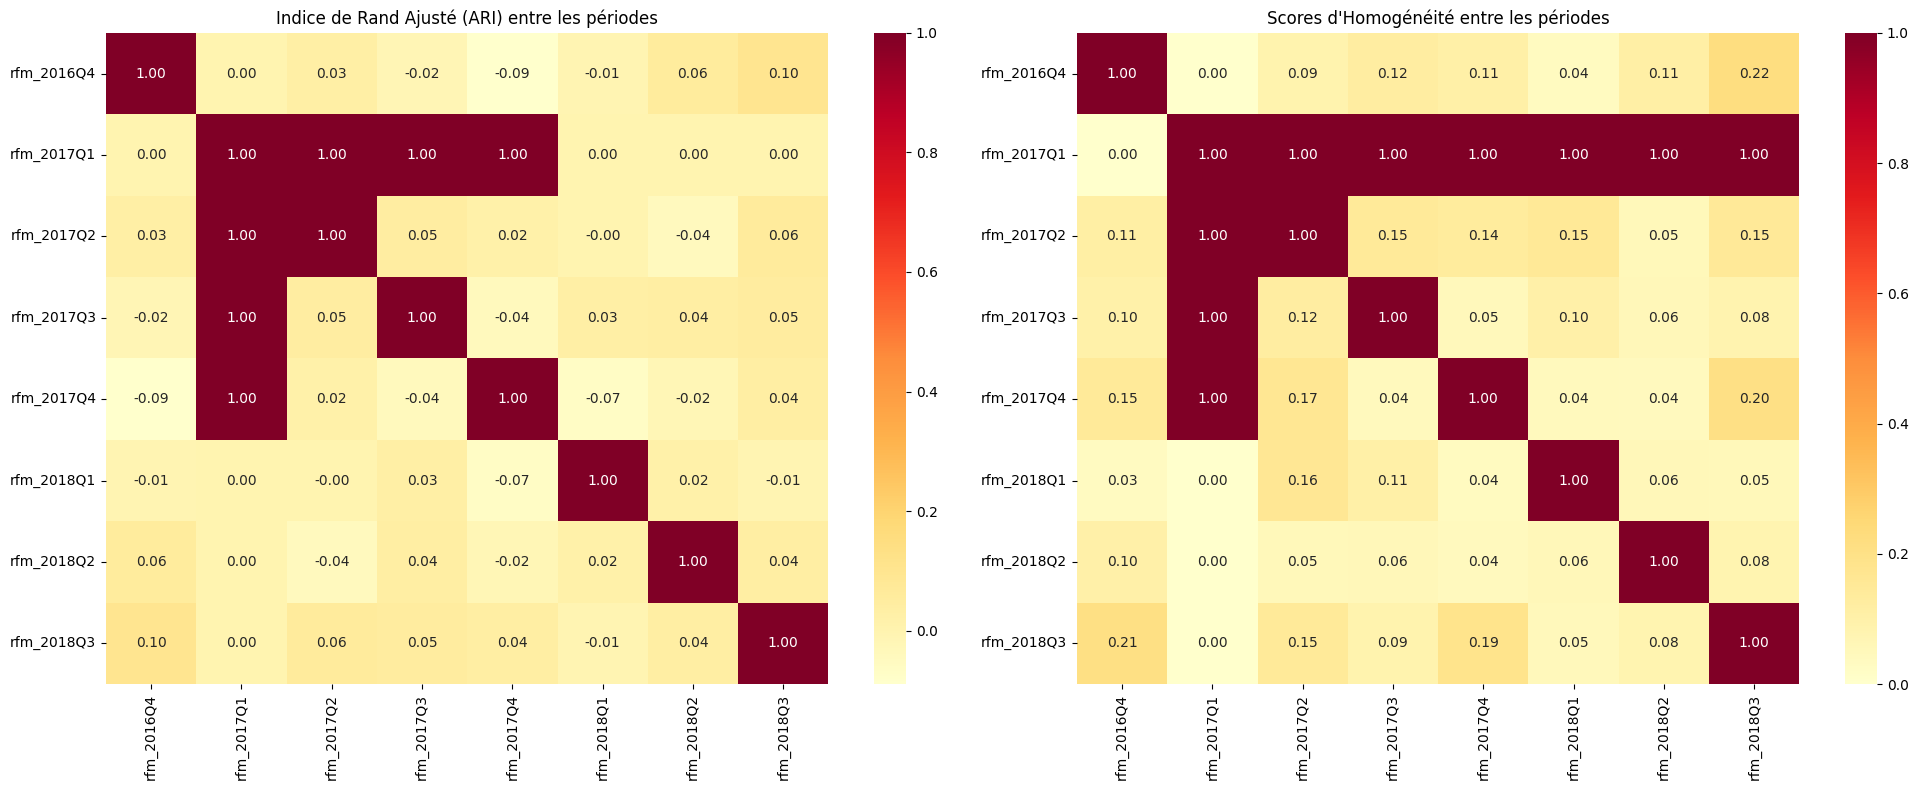

In [109]:
def plot_stability_metrics_ari_hs(stability_metrics, periods):
    """
    Visualise les métriques de stabilité en utilisant des cartes thermiques.
    """
    # Trier les périodes dans l'ordre chronologique
    periods_sorted = sorted(periods)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Tracer les scores ARI
    sns.heatmap(stability_metrics['ari_scores'], 
                annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=periods_sorted, yticklabels=periods_sorted, ax=axes[0])
    axes[0].set_title('Indice de Rand Ajusté (ARI) entre les périodes')
    
    # Tracer les scores d'homogénéité
    sns.heatmap(stability_metrics['homogeneity_scores'],
                annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=periods_sorted, yticklabels=periods_sorted, ax=axes[1])
    axes[1].set_title('Scores d\'Homogénéité entre les périodes')
    
    plt.tight_layout()
    plt.show()

plot_stability_metrics_ari_hs(stability_metrics, list(RFM_data_clustered.keys()))


<Figure size 3000x800 with 0 Axes>

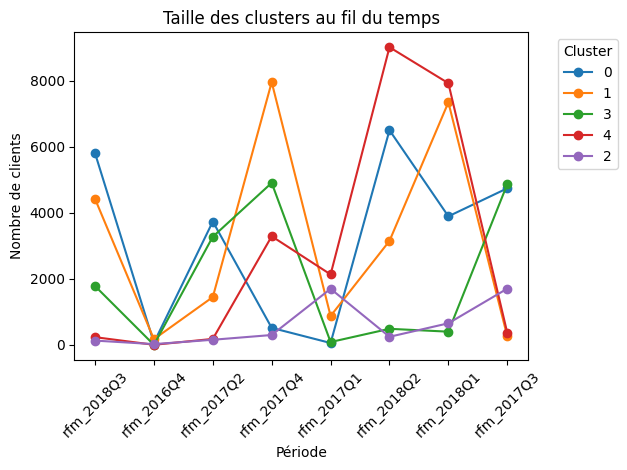

In [102]:
def plot_cluster_sizes(stability_metrics, periods):
    
    # Trier les périodes dans l'ordre chronologique
    periods_sorted = sorted(periods)
    
    # Créer une figure
    plt.figure(figsize=(30, 8))
    
    # Tracer les tailles des clusters au fil du temps
    sizes_df = pd.DataFrame(stability_metrics['cluster_sizes']).fillna(0)
    sizes_df = sizes_df.T
    sizes_df.plot(kind='line', marker='o')
    plt.title('Taille des clusters au fil du temps')
    plt.xlabel('Période')
    plt.ylabel('Nombre de clients')
    plt.xticks(rotation=45)
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_cluster_sizes(stability_metrics, list(RFM_data_clustered.keys()))


In [106]:
# Print summary statistics
def print_stability_summary(stability_metrics):

    periods = list(stability_metrics['cluster_sizes'].keys())
    periods_sorted = sorted(periods)
    print(periods_sorted)

    
    print("Cluster Stability Summary:")
    print("\nAverage ARI Score between consecutive periods:",
          np.mean([stability_metrics['ari_scores'][i,i+1] 
                  for i in range(len(periods_sorted)-1)]))
    
    print("\nAverage Homogeneity Score between consecutive periods:",
          np.mean([stability_metrics['homogeneity_scores'][i,i+1] 
                  for i in range(len(periods_sorted)-1)]))
    
    print("\nCluster Size Variation:")
    sizes_df = pd.DataFrame(stability_metrics['cluster_sizes']).fillna(0)
    sizes_df = sizes_df[sorted(sizes_df.columns)]
    print(sizes_df.std() / sizes_df.mean() * 100, "% (Coefficient of Variation)")

print_stability_summary(stability_metrics)

['rfm_2016Q4', 'rfm_2017Q1', 'rfm_2017Q2', 'rfm_2017Q3', 'rfm_2017Q4', 'rfm_2018Q1', 'rfm_2018Q2', 'rfm_2018Q3']
Cluster Stability Summary:

Average ARI Score between consecutive periods: 0.14234365618267614

Average Homogeneity Score between consecutive periods: 0.19726580515318193

Cluster Size Variation:
rfm_2016Q4    135.719343
rfm_2017Q1     96.545295
rfm_2017Q2     95.825487
rfm_2017Q3     95.505775
rfm_2017Q4     94.329001
rfm_2018Q1     88.089795
rfm_2018Q2     98.573920
rfm_2018Q3    102.791228
dtype: float64 % (Coefficient of Variation)
